<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/end-to-end-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-toend-Pipeline

In [ ]:
!nvidia-smi

Mon Nov 21 20:49:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installation Stuff

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 26.0 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
     |████████████████████████████████| 182 kB 69.6 MB/s 


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 26.3 MB/s 


## Mounting the personal drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Collective imports

In [ ]:
import re

from string import punctuation

import nltk
from textblob.en import subjectivity
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity
from nltk.corpus import stopwords

from typing import List, Tuple, Optional

import torch
import torch.nn as nn
import tensorflow as tf

import multiprocessing as mp

from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import logging
import gc

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import random

import numpy as np

from tqdm import tqdm

from torchinfo import summary

import operator

import math

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
nltk.download('subjectivity')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.


True

## Filtering text function

In [ ]:
def process(sent):
    # removing stopwords
    stop_list = set(stopwords.words("english"))
    sent = list(sent.lower().split())
    sent = ' '.join([word for word in sent if word not in stop_list])
    sent = re.sub(r'\n', '', sent)
    # Remove al numbersy
    sent = re.sub(r'[0-9]+', '',sent)
    # Remove HTML special entities
    sent = re.sub(r'\&\w*;', '', sent)
    # Convert @username to AT_USER
    sent = re.sub('@[^\s]+','',sent)
    # Remove tickers
    sent = re.sub(r'\$\w*', '', sent)
    # To lowercase
    sent = sent.lower()
    # Remove hyperlinks
    # sent = re.sub(r'https?:\/\/.*\/\w*', '', sent)
    sent = re.sub(r"http\S+", "", sent)
    # Remove hashtags
    sent = re.sub(r'#\w*', '', sent)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    sent = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', sent)
    # Remove words with 2 or fewer letters
    sent = re.sub(r'\b\w{1,2}\b', '', sent)
    # Remove whitespace (including new line characters)
    sent = re.sub(r'\s\s+', ' ', sent)
    # Remove single space remaining at the front of the sent.
    sent = sent.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    sent = ''.join(c for c in sent if c <= '\uFFFF') 
    return sent

## Datasets perparation

In [ ]:
def lol2str(doc):
    # flatten & join
    return " ".join([w for sent in doc for w in sent])

In [ ]:
def build_docs() -> Tuple[List[str], List[str], List[int], List[int]]:
    '''Used to fetch data and build list of sentences equivalent to documents
        Parameters :
        ------------
            None
        
        Return :
        ------------
            pol_corpus : list(str)
                List with polarity sentences
            subj_corpus : List(str)
                List with subjectivity sentences
            pol_labels : list(int)  
                List of labels for polarity dataset
            subj_labels : list(int)
                List of labels for subjectivity dataset
    '''

    # getting datasets from imported modules
    mr = movie_reviews
    sub = subjectivity
    neg = mr.paras(categories='neg')
    pos = mr.paras(categories='pos')

    # getting sentences from subj/obj dataset
    subj_docs = [sent for sent in subjectivity.sents(categories='subj')]
    obj_docs = [sent for sent in subjectivity.sents(categories='obj')]

    
    
    # collapse documents in a single big string
    pol_corpus = [lol2str(d) for d in pos] + [lol2str(d) for d in neg]
    pol_labels = [1 if idx<1000 else 0 for idx in range(2000)]

    # collapse splitted tokens in a single string
    subj_corpus = [process(' '.join(d)) for d in subj_docs] + [process(' '.join(d)) for d in obj_docs]
    subj_labels = [1 if idx<5000 else 0 for idx in range(10000)]

    seq_lengths_pol = np.array([len(s.split()) for s in pol_corpus])
    seq_lengths_subj = np.array([len(s.split()) for s in subj_corpus])

    print(f"Negative sentences count : {len(neg)},  Positive sentence count : {len(pos)}")
    print(f"Subjective sentences count : {len(subj_docs)}, Objective sentences count : {len(obj_docs)}")
    print(f"Polarity corpus length : {len(pol_corpus)}, Subjectivity corpus length : {len(subj_corpus)}")
    print(f" Percentiles results for polarity : {[(p, np.percentile(seq_lengths_pol,p)) for p in [75, 80, 90, 95, 99, 100]]}")
    print(f" Percentiles results for subjectivity : {[(p, np.percentile(seq_lengths_subj,p)) for p in [75, 80, 90, 95, 99, 100]]}")

    return pol_corpus, subj_corpus, pol_labels, subj_labels
    

## Custom Dataset Definition

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences: List[str], targets: List[int]):
        self.sentences = sentences
        self.targets = targets
        
    def __getitem__(self, index):
        sent = self.sentences[index]
        lab = self.targets[index]
        
        return sent, lab
    
    def __len__(self):
        return len(self.sentences)

## Collator

In [ ]:
class Collator(object):

    def __init__(self, tokenizer, model, device, max_len: int):
        
        if max_len > 512:
            raise ValueError('Maximum length accepted is 512')
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.max_len = max_len

    def __call__(self, data) -> Tuple:
        ''' This function will be passed to the desired dataloader
            Parameters :
            ------------
                data : dataset
                    list of sentences in an archive
            Return :
            ----------- -
                Returns a tuple of:
                    sents : list of tensors corresponding to the encoded sentence
                    labels : list of tensor labels
        '''

        sents = []
        labels = []
        
        self.model.eval()
        for (sent, label) in data:
            # tokenization of a sentence
            tokenized_sent = self.tokenizer.encode_plus(
                                                        sent,                               # untokenized sentence
                                                        add_special_tokens = True,          # add '[CLS]' and '[SEP]'
                                                        truncation = True,                  # truncate to maximum length
                                                        max_length = self.max_len,          # due to ram limiatation 
                                                        padding = "max_length",             # pad to maximum admissible sentence ['max_lenght', 'longest', 'True']
                                                        return_attention_mask = True,       # return attention mask
                                                        return_tensors = "pt"               # returns pytorch tensors
                                                       )

            # disable gradients            
            with torch.no_grad():
                last_hidden_state = self.model(
                                tokenized_sent['input_ids'].to(self.device), 
                                tokenized_sent['attention_mask'].to(self.device)
                           )
           
            # saving encodings and labels converted to tensors
            sents.append(last_hidden_state[0][0])
            labels.append(torch.tensor(label, dtype=torch.long))

            #sents.append(tokenized_sent["input_ids"])
            torch.cuda.empty_cache()

        sents = torch.stack(sents)
        labels = torch.stack(labels)
            
        return sents, labels

## DataLoaders

In [ ]:
def get_data(dataset, batch_size: int, collator, tst_dim_split: float=0.2, val_dim_split: int=0.1):
    # dividing into training and test set
    train_idx, test_idx = train_test_split(list(range(len(dataset.targets))), test_size=tst_dim_split,
                                                  stratify=dataset.targets, random_state=42)
    
    # splitting training set into training and validation
    train_idx, val_idx = train_test_split(train_idx, test_size=val_dim_split, random_state=42)

    # building subsets based on indexes
    train = Subset(dataset, train_idx)
    val = Subset(dataset, val_idx)
    test = Subset(dataset, test_idx)

    # definition of dataloaders
    train_loader = DataLoader(dataset=train, batch_size=batch_size, collate_fn=collator)
    val_loader = DataLoader(dataset=val, batch_size=batch_size, collate_fn=collator)
    test_loader = DataLoader(dataset=test, batch_size=batch_size, collate_fn=collator)

    print(f"Dataloader sizes after split:\nTraining : {len(train_loader)} Batches\nTest : {len(test_loader)} Batches\nValidation : {len(val_loader)} Batches")

    return train_loader, test_loader, val_loader

## Function to plot Gradient updates

In [ ]:
def plot_grad_flow(named_parameters: List) -> None:
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() to visualize the gradient flow
    
    Parameters : 
    ------------
        named_parameters : list
            model.named_parameters()
    
    Return : 
    ------------
        None
    '''

    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())                         # moving data to CPU to accomodate plt
            max_grads.append(p.grad.abs().max().cpu())                          
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], 
               ['max-gradient', 'mean-gradient', 'zero-gradient'],
                loc='best')

## Model Size computation

In [ ]:
def model_size(model) -> None :
    # element_size() returns size in bytes
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    size_all_mb = (param_size + buffer_size) / 1024**2
    print(f"Total number of parameters : {total_params}")
    print(f"Total nmber of trainable parameters : {total_trainable_params}")
    print(f'model size: {size_all_mb:.3f}MB')

## Print model parameters function

In [ ]:
def print_net_parameters(model) -> None:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)

## Initialization function

In [ ]:
def init_model(model):
    for param in model.parameters():
        param.requires_grad = True
    
    model=model.apply(init_weights)
    
    return model

## Random weight intialization function

In [ ]:
# took from laboratory 10

def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

## BiLSTM with attention Model

In [ ]:
class BiLSTMAttention(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 batch_first: bool=True, 
                 bidirectional: bool=True, 
                 num_heads: int=1):
        
        super(BiLSTMAttention, self).__init__()
        # BiLSTMs
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.bilstm = nn.LSTM(input_size=input_size,
                              hidden_size=hidden_size, batch_first=batch_first, 
                              bidirectional=bidirectional)

        # Attention layer
        #self.self_attn = MultiheadAttention(input_dim=input_size, embed_dim=input_size, num_heads=1) 
        # Layers to apply in between the main layers
        #self.norm1 = nn.LayerNorm(input_dim=input_size)
        #self.norm2 = nn.LayerNorm(input_dim=input_size)
        #self.dropout = nn.Dropout(p=0.35)

        self.dense = nn.Sequential(
            nn.Linear(in_features=2*hidden_size, out_features=64),
            nn.ReLU()
        )
       
        # dropout layer
        self.drop = nn.Dropout(p=0.35, inplace=False)
        
        # output linear layer
        self.out = nn.Linear(in_features=64, out_features=1)

    def forward(self, tens: torch.Tensor) -> torch.Tensor:
        tens, (state, cell) = self.bilstm(tens)

        #attn_out = self.self_attn(x, mask=mask)
        #tens = tens + self.dropout(attn_out)
        #tens = self.norm1(tens)

        tens = self.dense(tens)     
        tens = self.drop(tens)
        tens = self.out(tens)
        #tens = self.norm2(tens)

        return tens

## Early stopping

In [ ]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Loss Function

In [ ]:
def cross_entropy_loss():
    return torch.nn.CrossEntropyLoss()

## Optimizer

In [ ]:
def get_optimizer(net, lr: float=0.0002):
    return torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

## Training Step function

In [ ]:
def training_step(model, 
                  train: torch.utils.data.DataLoader,
                  cost_function: torch.nn.modules.loss, 
                  optimizer: torch.optim, 
                  device: str='cuda:0' 
                  ) -> None:  
    
    samples = 0.
    cumulative_accuracy= 0.
    cumulative_loss= 0.

    model.train()

    # iterate over the training set
    #for batch_idx, (pol_tensor, pol_label) in enumerate(pol_train):
    with tqdm(train, unit="batch") as tepoch: 
        for batch_idx, (tensor, label) in enumerate(tepoch):
            tepoch.set_description(f"# Batch for training step : {batch_idx}")

            # load polarity data to GPU
            inputs = tensor.to(device)
            labels = label.unsqueeze(-1).to(device)

            #print(f"Shape returned tensor : {(inputs.squeeze().type())}")
        
            # forward pass -> the output should be two vecotors.
            # as a consequence two losses
            out = model(inputs)

            # loss computation
            loss = cost_function(out, labels)
            loss.backward()
            plot_grad_flow(model.named_parameters())
        
            # parameters update
            optimizer.step()

            # fetch prediction and loss value for polarity 
            samples += inputs.shape[0]
            _, predicted = out.max(dim=1)

            # compute training accuracies
            cumulative_accuracy += torch.eq(predicted,labels).sum().item()

            tepoch.set_postfix(loss=loss.item(), 
                               accuracy=100.*(cumulative_accuracy/samples))
        
            # gradients reset
            optimizer.zero_grad()

    return loss, (cumulative_accuracy/samples)*100.

## Test Step

In [ ]:
def test_step(model, 
              test: torch.utils.data.DataLoader, 
              cost_function : torch.nn.modules.loss,
              device: str='cuda:0',
              kind: str="Test"
              ) -> Tuple[float]:

    samples = 0.
    cumulative_accuracy = 0.
    preds = []
    labs = []

    model.eval()

    with torch.no_grad():
        with tqdm(test, unit="batch") as tepoch:
            for batch_idx, (tensor, label) in enumerate(tepoch):

                tepoch.set_description(f"# Batch for {kind} step: {batch_idx}")

                # load polarity data to GPU
                inputs = tensor.to(device)
                labels = label.unsqueeze(-1).to(device)

                # forward pass
                out = model(inputs)

                # apply the loss
                loss = cost_function(out, labels)

                # getting predicted label
                # https://discuss.pytorch.org/t/how-does-one-get-the-predicted-classification-label-from-a-pytorch-model/91649/3
                pred = out.max(1).indices

                preds.append(pred)
                labs.append(label)
        
                # fetch prediction and loss value for polarity 
                samples += inputs.shape[0]
                _, predicted = out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

                # compute training accuracy
                cumulative_accuracy += predicted.eq(labels).sum().item()

                if kind != 'Polarity test':
                    tepoch.set_postfix(loss=loss.item(), 
                                       accuracy=100.*(cumulative_accuracy/samples))

    return loss, (cumulative_accuracy/samples)*100., preds, labs

## Plot results

In [ ]:
def plot_results(train_losses: List[float], 
                 val_losses: List[float], 
                 train_accs: List[float], 
                 val_accs: List[float], 
                 epochs: List[int],
                 path2file: str='') -> None:

    plt.figure(num=3, figsize=(10, 5)).patch.set_facecolor('white')
    plt.title('Train and Validation Losses')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.plot(train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.legend()
    
    plt.savefig(path2file+'/losses.png', dpi=100)
    plt.show()


    plt.figure(num=3, figsize=(10, 5)).patch.set_facecolor('white')
    plt.title('Train and Validation Accuracies')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(epochs, val_accs, label='Validation accuracy')
    plt.legend()

    plt.savefig(path2file+'/accuracies.png', dpi=100)
    plt.show()

    

## Save model

In [ ]:
def save_model(epochs: int, model, optimizer, criterion, path2file: str):
    '''Function to save the trained model to disk.
    '''
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path2file)

## Load model

In [ ]:
def load_model(model, path2file:str):
    # load a model checkpoint
    state_dict = torch.load(path2file)
    model.load_state_dict(state_dict['model_state_dict'])
    print(state_dict['model_state_dict'].keys())
    return model

## Wrapper

In [ ]:
def main(
         dataset,
         collator,
         early_stopper,
         seq_len : int,
         out: str,
         batch_size: int=128,
         device: str="cuda:0",
         epochs: int=30,
         tst_dim_split: float=0.2,
         val_dim_split: float=0.1,
         pr: bool=False,
         input: int=100,
         hidden: int=128
         ) -> Tuple[float]:

    torch.cuda.empty_cache()
    gc.collect()
    
    val_losses = []
    train_losses = []
    val_accs = []
    train_accs = []
    sampled_epochs = []

    # declaring and initializing the model
    print("Loading model ...")
    net = BiLSTMAttention(input_size=input, hidden_size=hidden).to(device)
    net = init_model(net)
    print('Network initialized')
    
    # print model summary -> keras.summary() style
    print(summary(model=net, input_size=(batch_size, seq_len, input)))

    # in case, print the parameters
    if pr:
        print_net_parameters(net)

    # assigning cost function
    cost_function = cross_entropy_loss()
    print('Got Loss')

    # assigning optimizer
    optimizer = get_optimizer(net)
    print("Got Optimizer")

    # bulding dataloader
    train_loader, test_loader, val_loader = get_data(dataset=dataset, 
                                                     batch_size=batch_size, 
                                                     collator=collator,
                                                     tst_dim_split=tst_dim_split,
                                                     val_dim_split=val_dim_split)
    
    print("Got Dataloaders")

    print("Starting the training ...")

    # training epochs
    for e in range(epochs):

        print(f"Epoch {e}:\t")
 
        train_loss, train_acc = training_step(model=net,
                                              train=train_loader, 
                                              cost_function=cost_function, 
                                              optimizer=optimizer, 
                                              device=device)

        val_loss, val_acc, _, _ = test_step(model=net,
                                            test=val_loader, 
                                            cost_function=cost_function,
                                            device=device,
                                            kind="Validation") 
        
        #print(train_loss.cpu().is_cuda)
        train_losses.append(train_loss.cpu().detach().item())
        val_losses.append(val_loss.cpu().detach().item())
        val_accs.append(val_acc)
        train_accs.append(train_acc)
        sampled_epochs.append(e)

        if early_stopper.early_stop(val_loss): 
            print(f"Saving model at epoch :{e+1} ...")            
            save_model(epochs=e+1, 
                       model=net, 
                       optimizer=optimizer, 
                       criterion=cost_function,
                       path2file=out)
            break

    print(f"Perfoming test step ...")
    _, _, _, _ = test_step(model=net, 
                           test=test_loader, 
                           cost_function=cost_function, 
                           device=device,
                           kind="Test")  
    
    print(f"\nSaving last model ...")
    save_model(epochs=epochs, 
               model=net, 
               optimizer=optimizer, 
               criterion=cost_function,
               path2file=out)
    
    print(f"Model Saved\n")
    
    return train_losses, val_losses, sampled_epochs, val_accs, train_accs

## Hyperparameters

In [ ]:
rootdir = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-and-Subjectivity-Detection/'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
nr_epochs = 10
BATCH_SIZE = 128
TST_SPLIT_DIM = 0.2
VAL_DIM_SPLIT = 0.1
RANDOM_STATE = 42
PATH2OUTPUTS = rootdir+'outputs/'
MIN_DELTA = 0.075

## Run

In [ ]:
def subj_run():
    torch.cuda.empty_cache()

    #preparing the datasets
    print('Preparing datasets ...')
    _, subj_corpus, _, subj_labels, max_subj_len = build_docs()

    # creating custom datasets
    print("Building custom datasets ...")
    #pol_dataset = CustomDataset(sentences=pol_corpus, targets=pol_labels)
    subj_dataset = CustomDataset(sentences=subj_corpus, targets=subj_labels)

    # to not see warning everytime
    logging.set_verbosity_error()

    # downloading BERT tokenier and model from huggingface.co
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")

    # instantiating collator
    print("Instantiating collator ...")
    collator = Collator(tokenizer=tokenizer, 
                        model=model.to(device), 
                        device=device, 
                        max_len=512)

    print("Instantiating stopper...")
    # initializing EarlyStopper
    early_stopper = EarlyStopper(patience=2, min_delta=MIN_DELTA)

    # main call
    train_losses, val_losses, sampled_epochs, val_accs, train_accs = main(dataset=subj_dataset, 
                                                                          collator=collator,
                                                                          early_stopper=early_stopper,
                                                                          seq_len=512,
                                                                          out=PATH2OUTPUTS+'/final_model.pth',
                                                                          batch_size=BATCH_SIZE, 
                                                                          device=device, 
                                                                          epochs=nr_epochs, 
                                                                          tst_dim_split=TST_SPLIT_DIM,
                                                                          val_dim_split=VAL_DIM_SPLIT,
                                                                          pr=False,
                                                                          input=768)
                                                                          
    plot_results(train_losses=train_losses, 
                 val_losses=val_losses, 
                 train_accs=train_accs,
                 val_accs=val_accs,
                 epochs=sampled_epochs,
                 path2file=PATH2OUTPUTS)

## Main

Preparing datasets ...
Negative sentences count : 1000,  Positive sentence count : 1000
Subjective sentences count : 5000, Objective sentences count : 5000
Polarity corpus length : 2000, Subjectivity corpus length : 10000
 Percentiles results for polarity : [(75, 957.25), (80, 1015.0), (90, 1231.1000000000001), (95, 1441.05), (99, 1921.2599999999998), (100, 2879.0)]
 Percentiles results for subjectivity : [(75, 15.0), (80, 16.0), (90, 19.0), (95, 21.0), (99, 28.0), (100, 66.0)]
Building custom datasets ...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Instantiating collator ...
Instantiating stopper...
Loading model ...
Network initialized
Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMAttention                          [128, 512, 1]             --
├─LSTM: 1-1                              [128, 512, 256]           919,552
├─Sequential: 1-2                        [128, 512, 64]            --
│    └─Linear: 2-1                       [128, 512, 64]            16,448
│    └─ReLU: 2-2                         [128, 512, 64]            --
├─Dropout: 1-3                           [128, 512, 64]            --
├─Linear: 1-4                            [128, 512, 1]             65
Total params: 936,065
Trainable params: 936,065
Non-trainable params: 0
Total mult-adds (G): 60.27
Input size (MB): 201.33
Forward/backward pass size (MB): 168.30
Params size (MB): 3.74
Estimated Total Size (MB): 373.37
Got Loss
Got Optimizer
Dataloader sizes after split:
Training : 57 Batches
Test : 16 Batches
Validation : 7 Batches


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.08s/batch, accuracy=52.6, loss=3.45]


Epoch 1:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=68.6, loss=0.627]


Epoch 2:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=86.1, loss=0.444]


Epoch 3:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=89.8, loss=0.341]


Epoch 4:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.12s/batch, accuracy=91.1, loss=0.313]


Epoch 5:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=91.6, loss=0.296]


Epoch 6:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=91.9, loss=0.297]


Epoch 7:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=91.8, loss=0.307]


Epoch 8:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.13s/batch, accuracy=91.8, loss=0.307]


Epoch 9:	


# Batch for Validation step: 6: 100%|██████████| 7/7 [00:28<00:00,  4.12s/batch, accuracy=91.5, loss=0.33]


Perfoming test step ...


# Batch for Test step: 15: 100%|██████████| 16/16 [01:12<00:00,  4.51s/batch, accuracy=90.5, loss=0.283]



Saving last model ...
Model Saved



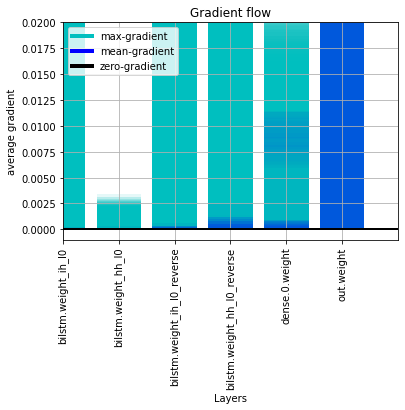

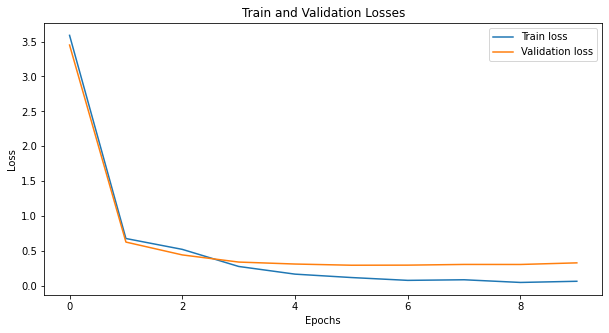

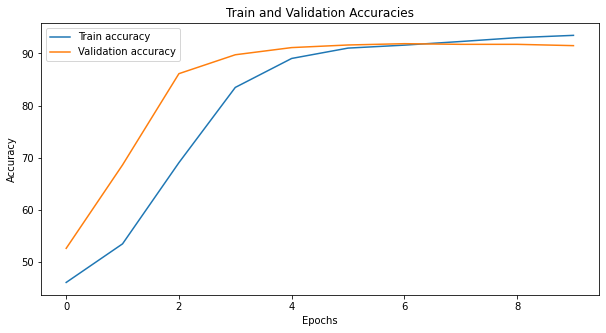

In [ ]:
if __name__ == '__main__':
    subj_run()

## Pipeline for classifing polarity sentences

In [ ]:
class CollatorPipeline(object):
    def __init__(self, tokenizer, model, device: str='cuda:0'):
        super().__init__()
        self.tokenizer = tokenizer
        self.model = model
        self.device = device

    def __call__(self, data):
        ''' This function will be passed to the desired dataloader
            Parameters :
            ------------
                data : dataset
                    list of sentences in an archive
            Return :
            ----------- -
                Returns a tuple of:
                    sents : list of integers corresponding to the sentiment prediction
                    labels : list of integers labels
        '''

        sentiments = []
        labels = []
        
        self.model.eval()
        for (sent, label) in data:
            # tokenization of a sentence
            tokenized_sent = self.tokenizer.encode_plus(
                                                        sent,                               # untokenized sentence
                                                        add_special_tokens = True,          # add '[CLS]' and '[SEP]'
                                                        truncation = True,                  # truncate to maximum length
                                                        max_length = 512,
                                                        padding = "max_length",             # pad to maximum admissible sentence ['max_lenght', 'longest', 'True']
                                                        return_attention_mask = True,       # return attention mask
                                                        return_tensors = "pt"               # returns pytorch tensors
                                                       )

            # disable gradients            
            with torch.no_grad():
                last_hidden_state = self.model(
                                tokenized_sent['input_ids'].to(self.device), 
                                tokenized_sent['attention_mask'].to(self.device)
                           )
           
            # saving encodings and labels converted to tensors
            sentiments.append(torch.argmax(last_hidden_state.logits).item()) # to get the sentiment prediction
            
            labels.append(label)

            #sents.append(tokenized_sent["input_ids"])
            torch.cuda.empty_cache()
            
        return sentiments, labels

In [ ]:
class PipelineMR():
    def __init__(self, 
                 corpus: List[str], 
                 labels: List[str], 
                 collator_pipe=None,
                 batch_size: int=None
                 ) -> None:

        self.corpus = corpus
        self.labels = labels
        self.batch_size = batch_size
        self.collator_pipe = collator_pipe

    def build_dataset(self):
        custom_dataset = CustomDataset(self.corpus, self.labels)
        return custom_dataset


    def build_dataloader(self) -> torch.utils.data.DataLoader:
        custom = self.build_dataset()
        data_out = DataLoader(dataset=custom, 
                              batch_size=self.batch_size, 
                              collate_fn=self.collator_pipe, 
                              shuffle=False)
        return data_out

    def predict(self):
        
        agreements = 0
        samples = 0
        print("Building DataLoader ...")
        dataloader = self.build_dataloader()
        for batch_idx, (sentiment, ground_truth) in enumerate(dataloader):
            print(f"# Batch {batch_idx}")
            
            agreements += sum(a == b for a, b in zip(sentiment, ground_truth))
            samples += len(sentiment)
            print(f"Agreements : {agreements}")

        accuracy = (agreements/samples)*100.
        print(f"Cumulative/final accuracy : {accuracy}")

In [ ]:
def pol_run():
    pol_corpus, _, pol_labels, _ = build_docs()

    # loading model 
    print("Loading model ...")
    net = BiLSTMAttention(input_size=768, hidden_size=128).to(device)
    net = load_model(model=net, path2file=PATH2OUTPUTS+'final_model.pth')

    # assigning cost function
    cost_function = cross_entropy_loss()
    print('Got Loss')

    # creating custom datasets
    print("Building custom datasets ...")
    pol_dataset = CustomDataset(sentences=pol_corpus, targets=pol_labels)

    # to not see warning everytime
    logging.set_verbosity_error()

    # downloading BERT tokenier and model from huggingface.co
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")

    print("Loading previously trained BertForSequenceClassification ...")
    PATH = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-and-Subjectivity-Detection/results'
    pre_clf = BertForSequenceClassification.from_pretrained(PATH, local_files_only=True)
     
    # instantiating collator
    print("Instantiating collator ...")
    collator = Collator(tokenizer=tokenizer, 
                        model=model.to(device), 
                        device=device, 
                        max_len=512)

    # bulding dataloader
    print("Building DataLoaders ...")
    test_loader = DataLoader(dataset=pol_dataset, 
                             batch_size=BATCH_SIZE, 
                             collate_fn=collator)


    # getting predictions from model
    _, _, preds, _ = test_step(model=net, 
                               test=test_loader, 
                               cost_function=cost_function, 
                               device=device,
                               kind="Polarity test")

    flat_preds = [l for ll in preds for id in ll for l in id]

    # indexes of subjective predicted sentences
    idx_subj_sents = [i for i, p in enumerate(flat_preds) if p==1]

    # getting indexes of subjective sentences
    filtered_sent_list = [pol_corpus[i] for i in idx_subj_sents]
    filtered_label_list = [pol_labels[i] for i in idx_subj_sents]

    print(f"Ended filtering. Remaining sentences : {len(filtered_sent_list)}")

    print("\nInstantiating pipeline collator ...")
    collator_pipe = CollatorPipeline(tokenizer=tokenizer, 
                                     model=pre_clf.to(device), 
                                     device=device)

    print("Initialising pipeline ...")
    pipe = PipelineMR(corpus=filtered_sent_list, 
                      labels=filtered_label_list, 
                      collator_pipe=collator_pipe, 
                      batch_size=BATCH_SIZE)

    pipe.predict()

In [ ]:
pol_run()

Negative sentences count : 1000,  Positive sentence count : 1000
Subjective sentences count : 5000, Objective sentences count : 5000
Polarity corpus length : 2000, Subjectivity corpus length : 10000
 Percentiles results for polarity : [(75, 957.25), (80, 1015.0), (90, 1231.1000000000001), (95, 1441.05), (99, 1921.2599999999998), (100, 2879.0)]
 Percentiles results for subjectivity : [(75, 15.0), (80, 16.0), (90, 19.0), (95, 21.0), (99, 28.0), (100, 66.0)]
Loading model ...
odict_keys(['bilstm.weight_ih_l0', 'bilstm.weight_hh_l0', 'bilstm.bias_ih_l0', 'bilstm.bias_hh_l0', 'bilstm.weight_ih_l0_reverse', 'bilstm.weight_hh_l0_reverse', 'bilstm.bias_ih_l0_reverse', 'bilstm.bias_hh_l0_reverse', 'dense.0.weight', 'dense.0.bias', 'out.weight', 'out.bias'])
Got Loss
Building custom datasets ...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Instantiating collator ...
Building DataLoaders ...


# Batch for Polarity test step: 15: 100%|██████████| 16/16 [01:39<00:00,  6.22s/batch]



Instantiating pipeline collator ...
Initialising pipeline ...
Building DataLoader ...
# Batch 0
Agreements : 118
# Batch 1
Agreements : 233
# Batch 2
Agreements : 354
# Batch 3
Agreements : 477
# Batch 4
Agreements : 595
# Batch 5
Agreements : 716
# Batch 6
Agreements : 832
# Batch 7
Agreements : 854
Cumulative/final accuracy : 92.82608695652173
